从LOF过来的文件。LOF+Grubbs+BN
---

In [1]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import theano.tensor as tt
from theano import shared
import pandas as pd
from matplotlib import gridspec
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import scale
from mpl_toolkits.mplot3d import Axes3D
# import sklearn as sl
# from sklearn.neighbors import LocalOutlierFactor

D:\Softwares\Python\Python_Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# plt.style.use('default')
font1 ={'family': 'times', 'weight':'light', 'size': 12}  
# font2 ={'family': 'Arial', 'weight':'normal', 'size': 12}  
def Plot_XZ(elec_year, elec_faults):
# 画出原始图
    Company_names = ['Xizang', 'Xinjiang', 'Heilongjiang']
    j= 0
    plt.figure(figsize=(4, 3), facecolor='w')
    ax = plt.subplot(1, 1, 1)
    for jx in range(11):
        ax.plot(elec_year[jx], elec_faults[jx], 'ko--', markersize=3, linewidth=1)
        # j = j+k1
    ax.set_xticklabels(['2016', '2010', '2011', '2012', '2013', '2014', '2015'], fontsize='small')
    ax.set_xlabel("time(year)", fontdict=font1)
    plt.ylabel("Failure rate(%)", fontdict=font1)
    plt.legend([Company_names[0]], loc='upper left', frameon=False, fontsize='small')

    plt.show()
    return 0

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


D:\Softwares\Python\Python_Anaconda\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family ['times'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


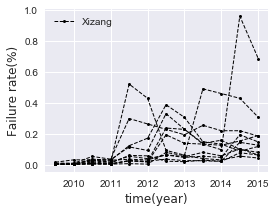

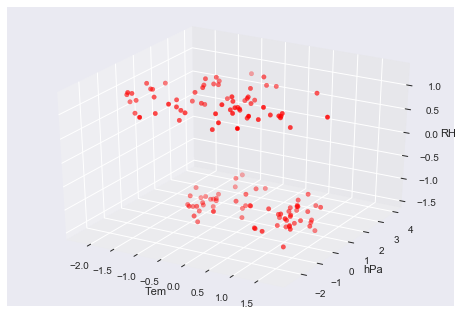

In [3]:
np.set_printoptions(precision=0, suppress=True)
Savefig = 0 # 控制图形显示存储

elec_data = pd.read_csv('XZnozero_12_longB.csv')

# 计算同一公司产品测试地点数目：
companies_num = elec_data.counts.unique()
companies = len(companies_num)  # companies=7， 共7个测试地点
company_lookup = dict(zip(companies_num, range(len(companies_num))))
company = elec_data['company_code'] = elec_data.counts.replace(company_lookup).values  # 加一行数据在XZsingal文件中
# companys = elec_data.counts.values - 1 # 这一句以上面两行功能相同

# 计算不同公司数目
company_ABC = elec_data.company.unique()
companiesABC = len(company_ABC)  # companies=7， 共7个测试地点
company_lookup_ABC = dict(zip(company_ABC, range(len(company_ABC))))
companyABC = elec_data['company_ABC'] = elec_data.company.replace(company_lookup_ABC).values  # 加一行数据在XZsingal文件中




# 给所有特征因素加上高斯噪声
SNR = np.random.normal(0, 2, size=[len(elec_data.Year.values), 4])
SNR_Tem = np.random.normal(0, 0.5, size=[len(elec_data.Year.values), 1])
# #特征因素分析

elec_tem = elec_data.Tem.values + SNR_Tem[:, 0] # 观测温度值x2
elec_tem1 = (elec_tem - np.mean(elec_tem)) / np.std(elec_tem)
elec_hPa = elec_data.hPa.values + SNR[:, 1]  # 观测压强x3
elec_hPa1 = (elec_hPa - np.mean(elec_hPa)) / np.std(elec_hPa)
elec_RH = elec_data.RH.values + SNR[:, 2] # 观测压强x3
elec_RH1 = (elec_RH - np.mean(elec_RH)) / np.std(elec_RH)
elec_Lux = elec_data.Lux.values + SNR[:, 3] # 观测压强x3
elec_Lux1 = (elec_Lux - np.mean(elec_Lux)) / np.std(elec_Lux)

# 计算观测时间，温度，光照等环境条件
elec_year = elec_data.Year.values  # 观测时间值x1
elec_year1 = (elec_year - np.mean(elec_year)) / np.std(elec_year)

elec_data.Fault.values[118] =210
elec_data.Fault.values[119] =150
# 计算故障率大小：故障数目/总测量数，作为模型Y值，放大100倍以增加实际效果，结果中要缩小100倍
elec_faults = 100 * (elec_data.Fault.values / elec_data.Nums.values)  # 数组形式,计算故障率大小
elec_faults1 = (elec_faults - np.mean(elec_faults)) / np.std(elec_faults)

print(elec_faults)
# 将故障率以6组一行形式组成数组,变成：21*6
elec_faults2 = np.array([elec_faults[i*12:(i+1)*12] for i in np.arange(11)])
elec_year2 = np.array([elec_year[i*12:(i+1)*12] for i in np.arange(11)])

# 画图
Plot_XZ(elec_year2, elec_faults2)

# plt.figure(figsize=(4, 3), facecolor='w')
ax = plt.subplot(111, projection='3d')
ax.scatter(elec_tem1, elec_hPa1, elec_RH1, c='r')
ax.set_zlabel('RH')  # 坐标轴
ax.set_ylabel('hPa')
ax.set_xlabel('Tem')
plt.show()

In [4]:
from lof import *
# Instane2_A, Instane2_B, Instane2_C：为故障+时间
# Instane5_A, Instane5_B, Instane5_C：为故障+时间+温度+压强+湿度
# 矩阵乘以权重需要将list转换为Numpy: np.array(Instane),才能调用切片
# 权重矩阵Weight为：
Weight = np.array([1.0, 0.7374600235314777, 0.4227377446415122 ,0.35389055980896444 ,0.6336980373474057])
# 注意，一下数据全部已经和权重相乘了
Instane2_A =[
[ -0.8026384567926785 , -1.1749618798442447 ] ,
[ -0.8026384567926785 , -0.9613324471452911 ] ,
[ -0.8026384567926785 , -0.7477030144463375 ] ,
[ -0.8026384567926785 , -0.5340735817473838 ] ,
[ -0.7108600304388067 , -0.3204441490484303 ] ,
[ -0.7475714009803555 , -0.10681471634947677 ] ,
[ -0.453880436647966 , 0.10681471634947677 ] ,
[ -0.03169967542015602 , 0.3204441490484303 ] ,
[ 0.40883677107842814 , 0.5340735817473838 ] ,
[ 0.7392391059523664 , 0.7477030144463375 ] ,
[ -0.2703235839402225 , 0.9613324471452911 ] ,
[ 0.041723065662941324 , 1.1749618798442447 ] ,
[ -0.44358896457146485 , -1.1749618798442447 ] ,
[ -0.44358896457146485 , -0.9613324471452911 ] ,
[ -0.44358896457146485 , -0.7477030144463375 ] ,
[ -0.06618378707947692 , -0.5340735817473838 ] ,
[ -0.44358896457146485 , -0.3204441490484303 ] ,
[ -0.06618378707947692 , -0.10681471634947677 ] ,
[ 0.311221390412511 , 0.10681471634947677 ] ,
[ -0.06618378707947692 , 0.3204441490484303 ] ,
[ 1.443436922888475 , 0.5340735817473838 ] ,
[ 1.066031745396487 , 0.7477030144463375 ] ,
[ 1.443436922888475 , 0.9613324471452911 ] ,
[ 2.1982472778724507 , 1.1749618798442447 ] ,
[ -0.8101188301005176 , -1.1749618798442447 ] ,
[ -0.8101188301005176 , -0.9613324471452911 ] ,
[ -0.7992435181375823 , -0.7477030144463375 ] ,
[ -0.8101188301005176 , -0.5340735817473838 ] ,
[ -0.6578644626194238 , -0.3204441490484303 ] ,
[ -0.6904903985082297 , -0.10681471634947677 ] ,
[ -0.33160510373136576 , 0.10681471634947677 ] ,
[ -0.3751063515831068 , 0.3204441490484303 ] ,
[ -0.7013657104711649 , 0.5340735817473838 ] ,
[ -0.7122410224341001 , 0.7477030144463375 ] ,
[ -0.3207297917684304 , 0.9613324471452911 ] ,
[ -0.16847542428733672 , 1.1749618798442447 ] ,
[ -0.6834314801440002 , -1.1749618798442447 ] ,
[ -0.6834314801440002 , -0.9613324471452911 ] ,
[ -0.4633312210728759 , -0.7477030144463375 ] ,
[ -0.4908437534567664 , -0.5340735817473838 ] ,
[ -0.6008938829923285 , -0.3204441490484303 ] ,
[ -0.6559189477601096 , -0.10681471634947677 ] ,
[ -0.4908437534567664 , 0.10681471634947677 ] ,
[ -0.7109440125278906 , 0.3204441490484303 ] ,
[ -0.4633312210728759 , 0.5340735817473838 ] ,
[ -0.43581868868898527 , 0.7477030144463375 ] ,
[ 0.5271199447471835 , 0.9613324471452911 ] ,
[ 0.5821450095149646 , 1.1749618798442447 ] ,
[ -0.7492931584222882 , -1.1749618798442447 ] ,
[ -0.6775921747811235 , -0.9613324471452911 ] ,
[ -0.7492931584222882 , -0.7477030144463375 ] ,
[ -0.7492931584222882 , -0.5340735817473838 ] ,
[ -0.31908725657530035 , -0.3204441490484303 ] ,
[ -0.46248922385762964 , -0.10681471634947677 ] ,
[ 0.32622159619518154 , 0.10681471634947677 ] ,
[ 0.18281962891285214 , 0.3204441490484303 ] ,
[ -0.10398430565180646 , 0.5340735817473838 ] ,
[ -0.03228332201064176 , 0.7477030144463375 ] ,
[ -0.46248922385762964 , 0.9613324471452911 ] ,
[ -0.46248922385762964 , 1.1749618798442447 ] ,
[ -0.6597790617764374 , -1.1749618798442447 ] ,
[ -0.6597790617764374 , -0.9613324471452911 ] ,
[ -0.6597790617764374 , -0.7477030144463375 ] ,
[ -0.17613382091539118 , -0.5340735817473838 ] ,
[ -0.6597790617764374 , -0.3204441490484303 ] ,
[ -0.49856398148942194 , -0.10681471634947677 ] ,
[ -0.49856398148942194 , 0.10681471634947677 ] ,
[ -0.17613382091539118 , 0.3204441490484303 ] ,
[ 1.9196622228158093 , 0.5340735817473838 ] ,
[ 2.4033074636768554 , 0.7477030144463375 ] ,
[ 2.24209238338984 , 0.9613324471452911 ] ,
[ 2.4033074636768554 , 1.1749618798442447 ] ,
[ -0.7554895397246111 , -1.1749618798442447 ] ,
[ -0.7554895397246111 , -0.9613324471452911 ] ,
[ -0.6899849373857693 , -0.7477030144463375 ] ,
[ -0.6244803350469275 , -0.5340735817473838 ] ,
[ 0.030565688341490274 , -0.3204441490484303 ] ,
[ -0.10044351633619333 , -0.10681471634947677 ] ,
[ 2.061208360845585 , 0.10681471634947677 ] ,
[ 2.454235974878636 , 0.3204441490484303 ] ,
[ 2.8472635889116864 , 0.5340735817473838 ] ,
[ 2.454235974878636 , 0.7477030144463375 ] ,
[ 1.86469455382906 , 0.9613324471452911 ] ,
[ 1.9957037585067434 , 1.1749618798442447 ]
]


Instane2_B =[
[ -0.4774983366679871 , -1.1749618798442447 ] ,
[ -0.4774983366679871 , -0.9613324471452911 ] ,
[ -0.33611527423046855 , -0.7477030144463375 ] ,
[ -0.3658175982719641 , -0.5340735817473838 ] ,
[ -0.33967955311544806 , -0.3204441490484303 ] ,
[ -0.3563128545786855 , -0.10681471634947677 ] ,
[ -0.2184940710261464 , 0.10681471634947677 ] ,
[ -0.267205882454199 , 0.3204441490484303 ] ,
[ -0.15314895813485638 , 0.5340735817473838 ] ,
[ -0.24700830210598212 , 0.7477030144463375 ] ,
[ -0.05691342824041098 , 0.9613324471452911 ] ,
[ -0.22324644287278572 , 1.1749618798442447 ] ,
[ -0.4791776090200767 , -1.1749618798442447 ] ,
[ -0.4791776090200767 , -0.9613324471452911 ] ,
[ -0.4573804673485997 , -0.7477030144463375 ] ,
[ -0.4628297527664689 , -0.5340735817473838 ] ,
[ -0.37564118608056063 , -0.3204441490484303 ] ,
[ -0.3919890423341685 , -0.10681471634947677 ] ,
[ -0.3374961881554758 , 0.10681471634947677 ] ,
[ -0.37564118608056063 , 0.3204441490484303 ] ,
[ -0.3810904714984299 , 0.5340735817473838 ] ,
[ -0.39743832775203775 , 0.7477030144463375 ] ,
[ -0.1631190547836592 , 0.9613324471452911 ] ,
[ -0.22306119438022112 , 1.1749618798442447 ] ,
[ -0.4714664686562114 , -1.1749618798442447 ] ,
[ -0.4714664686562114 , -0.9613324471452911 ] ,
[ -0.4188247655292731 , -0.7477030144463375 ] ,
[ -0.44514561709274225 , -0.5340735817473838 ] ,
[ -0.23457880458498898 , -0.3204441490484303 ] ,
[ -0.24773923036672355 , -0.10681471634947677 ] ,
[ -0.3925039139658039 , 0.10681471634947677 ] ,
[ -0.40566433974753857 , 0.3204441490484303 ] ,
[ -0.3661830624023348 , 0.5340735817473838 ] ,
[ -0.3925039139658039 , 0.7477030144463375 ] ,
[ 0.12075269152184467 , 0.9613324471452911 ] ,
[ 0.04179013683143726 , 1.1749618798442447 ] ,
[ -0.4477862315143532 , -1.1749618798442447 ] ,
[ -0.4477862315143532 , -0.9613324471452911 ] ,
[ -0.2635829168963893 , -0.7477030144463375 ] ,
[ -0.3372642427435749 , -0.5340735817473838 ] ,
[ 0.7679556449642087 , -0.3204441490484303 ] ,
[ 0.6205929932698376 , -0.10681471634947677 ] ,
[ 0.47323034157546645 , 0.10681471634947677 ] ,
[ 0.3258676898810953 , 0.3204441490484303 ] ,
[ 0.5837523303462449 , 0.5340735817473838 ] ,
[ 0.43638967865187367 , 0.7477030144463375 ] ,
[ 0.43638967865187367 , 0.9613324471452911 ] ,
[ 0.28902702695750254 , 1.1749618798442447 ] ,
[ -0.4521846077449349 , -1.1749618798442447 ] ,
[ -0.4521846077449349 , -0.9613324471452911 ] ,
[ -0.3873000343589126 , -0.7477030144463375 ] ,
[ -0.4197423210519237 , -0.5340735817473838 ] ,
[ -0.25753088758686804 , -0.3204441490484303 ] ,
[ -0.32241546097289037 , -0.10681471634947677 ] ,
[ -0.22508860089385688 , 0.10681471634947677 ] ,
[ -0.2899731742798792 , 0.3204441490484303 ] ,
[ -0.25753088758686804 , 0.5340735817473838 ] ,
[ -0.2899731742798792 , 0.7477030144463375 ] ,
[ 0.3264302728873324 , 0.9613324471452911 ] ,
[ 0.1317765527292657 , 1.1749618798442447 ] ,
[ -0.4202389120008448 , -1.1749618798442447 ] ,
[ -0.35585092956374353 , -0.9613324471452911 ] ,
[ -0.35585092956374353 , -0.7477030144463375 ] ,
[ -0.4202389120008448 , -0.5340735817473838 ] ,
[ 1.7045645084234964 , -0.3204441490484303 ] ,
[ 1.318236613800889 , -0.10681471634947677 ] ,
[ -0.09829899981533852 , 0.10681471634947677 ] ,
[ -0.22707496468954103 , 0.3204441490484303 ] ,
[ 1.575788543549294 , 0.5340735817473838 ] ,
[ 1.4470125786750914 , 0.7477030144463375 ] ,
[ 1.318236613800889 , 0.9613324471452911 ] ,
[ 0.8031327543040788 , 1.1749618798442447 ] ,
[ -0.4719158471088558 , -1.1749618798442447 ] ,
[ -0.4719158471088558 , -0.9613324471452911 ] ,
[ -0.4719158471088558 , -0.7477030144463375 ] ,
[ -0.4719158471088558 , -0.5340735817473838 ] ,
[ -0.4592047997797656 , -0.3204441490484303 ] ,
[ -0.4719158471088558 , -0.10681471634947677 ] ,
[ -0.15413966388160044 , 0.10681471634947677 ] ,
[ -0.24311699518523197 , 0.3204441490484303 ] ,
[ -0.31938327915977327 , 0.5340735817473838 ] ,
[ -0.35751642114704385 , 0.7477030144463375 ] ,
[ -0.2558280425143222 , 0.9613324471452911 ] ,
[ -0.30667223183068304 , 1.1749618798442447 ] ,
[ -0.4793642718101598 , -1.1749618798442447 ] ,
[ -0.4793642718101598 , -0.9613324471452911 ] ,
[ -0.4583137812990148 , -0.7477030144463375 ] ,
[ -0.4741016491823735 , -0.5340735817473838 ] ,
[ -0.3793744418822211 , -0.3204441490484303 ] ,
[ -0.4162128002767248 , -0.10681471634947677 ] ,
[ 0.32581699024113586 , 0.10681471634947677 ] ,
[ 0.09426159461854107 , 0.3204441490484303 ] ,
[ 0.0732111041073961 , 0.5340735817473838 ] ,
[ 0.04163536834067853 , 0.7477030144463375 ] ,
[ 0.15741306615197598 , 0.9613324471452911 ] ,
[ 0.30476649972999087 , 1.1749618798442447 ] ,
[ -0.4632101290359002 , -1.1749618798442447 ] ,
[ -0.47391878433277124 , -0.9613324471452911 ] ,
[ -0.3561328441594869 , -0.7477030144463375 ] ,
[ -0.36684367993171196 , -0.5340735817473838 ] ,
[ 0.029323140805040226 , -0.3204441490484303 ] ,
[ 0.23274343621916757 , -0.10681471634947677 ] ,
[ 1.1427987003431712 , 0.10681471634947677 ] ,
[ 0.8001500841410427 , 0.3204441490484303 ] ,
[ 0.1363328402826389 , 0.5340735817473838 ] ,
[ 0.07208145713371895 , 0.7477030144463375 ] ,
[ -0.12063454396217987 , 0.9613324471452911 ] ,
[ 0.007820811413803471 , 1.1749618798442447 ] ,
[ -0.4654008471203546 , -1.1749618798442447 ] ,
[ -0.4654008471203546 , -0.9613324471452911 ] ,
[ -0.36927061053239757 , -0.7477030144463375 ] ,
[ -0.35004456321480615 , -0.5340735817473838 ] ,
[ -0.003975711498160821 , -0.3204441490484303 ] ,
[ -0.10010594808611784 , -0.10681471634947677 ] ,
[ 0.8996485124286354 , 0.10681471634947677 ] ,
[ 0.47667547144162437 , 0.3204441490484303 ] ,
[ 0.0729284777722049 , 0.5340735817473838 ] ,
[ -0.08087990076852643 , 0.7477030144463375 ] ,
[ 9.128396764357758 , 0.9613324471452911 ] ,
[ 4.283432840324724 , 1.1749618798442447 ] ,
[ -0.47800222415019095 , -1.1749618798442447 ] ,
[ -0.47137755386243596 , -0.9613324471452911 ] ,
[ -0.4515035429991708 , -0.7477030144463375 ] ,
[ -0.46475288357468086 , -0.5340735817473838 ] ,
[ -0.38525684012162026 , -0.3204441490484303 ] ,
[ -0.40513085098488544 , -0.10681471634947677 ] ,
[ 0.5090736487253116 , 0.10681471634947677 ] ,
[ 0.4726379621426588 , 0.3204441490484303 ] ,
[ 0.09503175574062094 , 0.5340735817473838 ] ,
[ 0.17784013433755894 , 0.7477030144463375 ] ,
[ -0.07058500145325536 , 0.9613324471452911 ] ,
[ -0.15339338005019354 , 1.1749618798442447 ]
]


Instane2_C =[ 
[ -1.0757395478020817 , -1.1749618798442447 ] ,
[ -1.0929904254942013 , -0.9613324471452911 ] ,
[ -1.0757395478020817 , -0.7477030144463375 ] ,
[ -1.0584886701099623 , -0.5340735817473838 ] ,
[ -0.885979893188768 , -0.3204441490484303 ] ,
[ -0.9377325262651264 , -0.10681471634947677 ] ,
[ -0.644467605499096 , 0.10681471634947677 ] ,
[ -0.5409623393463794 , 0.3204441490484303 ] ,
[ -0.16144303011975164 , 0.5340735817473838 ] ,
[ -0.2649482962724683 , 0.7477030144463375 ] ,
[ -0.3339518070409462 , 0.9613324471452911 ] ,
[ -0.29945005165670724 , 1.1749618798442447 ] ,
[ -1.1043831061295037 , -1.1749618798442447 ] ,
[ -1.1043831061295037 , -0.9613324471452911 ] ,
[ -1.098524909072687 , -0.7477030144463375 ] ,
[ -1.0868085149590532 , -0.5340735817473838 ] ,
[ -0.6884511150955038 , -0.3204441490484303 ] ,
[ -0.7587494797773066 , -0.10681471634947677 ] ,
[ -0.05576583295927844 , 0.10681471634947677 ] ,
[ -0.0030420594479262735 , 0.3204441490484303 ] ,
[ -0.4658396269364615 , 0.5340735817473838 ] ,
[ -0.33110109462967285 , 0.7477030144463375 ] ,
[ 0.3425915669042707 , 0.9613324471452911 ] ,
[ 0.17856204931339764 , 1.1749618798442447 ] ,
[ -1.1011579520182484 , -1.1749618798442447 ] ,
[ -1.1011579520182484 , -0.9613324471452911 ] ,
[ -0.8831575239845124 , -0.7477030144463375 ] ,
[ -0.9013242263206571 , -0.5340735817473838 ] ,
[ -0.4744067214212575 , -0.3204441490484303 ] ,
[ -0.23823959105137676 , -0.10681471634947677 ] ,
[ -0.31998975156402776 , 0.10681471634947677 ] ,
[ -0.38357320974053416 , 0.3204441490484303 ] ,
[ -0.22007288871523206 , 0.5340735817473838 ] ,
[ -0.111072674698364 , 0.7477030144463375 ] ,
[ -0.25640629338752136 , 0.9613324471452911 ] ,
[ -0.20190618637908747 , 1.1749618798442447 ] ,
[ -1.0360890771731874 , -1.1749618798442447 ] ,
[ -1.073165190179754 , -0.9613324471452911 ] ,
[ -0.7765562861272208 , -0.7477030144463375 ] ,
[ -0.8507085121403541 , -0.5340735817473838 ] ,
[ 0.1874226520435123 , -0.3204441490484303 ] ,
[ 0.0020420870106791214 , -0.10681471634947677 ] ,
[ 0.8177165731551457 , 0.10681471634947677 ] ,
[ 1.4109343812602122 , 0.3204441490484303 ] ,
[ 1.781695511325879 , 0.5340735817473838 ] ,
[ 1.5592388332864786 , 0.7477030144463375 ] ,
[ 1.0401732511945454 , 0.9613324471452911 ] ,
[ 1.1514015902142454 , 1.1749618798442447 ] ,
[ -0.8802406908707534 , -1.1749618798442447 ] ,
[ -0.8802406908707534 , -0.9613324471452911 ] ,
[ -0.6502400785551861 , -0.7477030144463375 ] ,
[ -0.8802406908707534 , -0.5340735817473838 ] ,
[ -0.1902388539240514 , -0.3204441490484303 ] ,
[ 0.26976237070708337 , -0.10681471634947677 ] ,
[ -0.1902388539240514 , 0.10681471634947677 ] ,
[ -0.42023946623961866 , 0.3204441490484303 ] ,
[ 0.7297635953382179 , 0.5340735817473838 ] ,
[ 0.4997629830226505 , 0.7477030144463375 ] ,
[ 0.26976237070708337 , 0.9613324471452911 ] ,
[ 0.4997629830226505 , 1.1749618798442447 ] ,
[ 0.24109373914366977 , -1.1749618798442447 ] ,
[ -0.43457378202132546 , -0.9613324471452911 ] ,
[ -0.43457378202132546 , -0.7477030144463375 ] ,
[ -0.43457378202132546 , -0.5340735817473838 ] ,
[ 0.9167612603086652 , -0.3204441490484303 ] ,
[ 0.9167612603086652 , -0.10681471634947677 ] ,
[ 0.24109373914366977 , 0.10681471634947677 ] ,
[ -0.43457378202132546 , 0.3204441490484303 ] ,
[ 2.268096302638656 , 0.5340735817473838 ] ,
[ 1.5924287814736604 , 0.7477030144463375 ] ,
[ 2.268096302638656 , 0.9613324471452911 ] ,
[ 2.943763823803651 , 1.1749618798442447 ] ,
[ -0.7369852234191169 , -1.1749618798442447 ] ,
[ -0.7369852234191169 , -0.9613324471452911 ] ,
[ -0.3637291436519128 , -0.7477030144463375 ] ,
[ -0.7369852234191169 , -0.5340735817473838 ] ,
[ 0.009526936115291103 , -0.3204441490484303 ] ,
[ 0.38278301588249514 , -0.10681471634947677 ] ,
[ 1.129295175416903 , 0.10681471634947677 ] ,
[ 1.5025512551841071 , 0.3204441490484303 ] ,
[ 1.8758073349513111 , 0.5340735817473838 ] ,
[ 1.5025512551841071 , 0.7477030144463375 ] ,
[ 2.249063414718515 , 0.9613324471452911 ] ,
[ 2.6223194944857187 , 1.1749618798442447 ]
]


Instane5_A =[ 
[ -0.8026384567926785 , -1.1749618798442447 , 0.05696231167852711 , 0.11496102009640646 , 0.737555100407867 ] ,
[ -0.8026384567926785 , -0.9613324471452911 , 0.40707507375232743 , 0.15187943492286463 , -0.6234956754736902 ] ,
[ -0.8026384567926785 , -0.7477030144463375 , 0.04398670198424266 , 0.09875620823685456 , 0.49877220274404593 ] ,
[ -0.8026384567926785 , -0.5340735817473838 , 0.4383123100923998 , 0.13710940056062806 , -0.6630881676744813 ] ,
[ -0.7108600304388067 , -0.3204441490484303 , -0.4588778099484288 , 0.33162938916980816 , 0.6696595923007634 ] ,
[ -0.7475714009803555 , -0.10681471634947677 , 0.2746827367740511 , -0.45548002582278585 , -0.7346029811138731 ] ,
[ -0.453880436647966 , 0.10681471634947677 , -0.6386707416620522 , 0.46993980297840143 , 0.6447492125602874 ] ,
[ -0.03169967542015602 , 0.3204441490484303 , 0.22240258215466738 , -0.14283017909395077 , -0.6016134905315047 ] ,
[ 0.40883677107842814 , 0.5340735817473838 , -0.706347343569398 , 0.1421783914710769 , 0.71154274003882 ] ,
[ 0.7392391059523664 , 0.7477030144463375 , 0.4352473325598387 , -0.5510437261171098 , -0.43086948554213617 ] ,
[ -0.2703235839402225 , 0.9613324471452911 , -0.4473705673671871 , -0.05047958332257731 , 0.6922990044662027 ] ,
[ 0.041723065662941324 , 1.1749618798442447 , 0.24912838129523965 , -0.09262839755858393 , -0.6967031566718178 ] ,
[ -0.44358896457146485 , -1.1749618798442447 , 0.04233346856611191 , 0.5799691682159045 , 0.5046714726851071 ] ,
[ -0.44358896457146485 , -0.9613324471452911 , 0.3337794229703937 , -0.13161404600994425 , -0.6887678661178971 ] ,
[ -0.44358896457146485 , -0.7477030144463375 , 0.2979202992119596 , -0.6210600235063429 , 0.5508736908625448 ] ,
[ -0.06618378707947692 , -0.5340735817473838 , 0.48697442120779016 , 0.016905656777207265 , -0.7965657706234923 ] ,
[ -0.44358896457146485 , -0.3204441490484303 , -0.4180433876025004 , 0.7606285892862858 , 0.6840581811260454 ] ,
[ -0.06618378707947692 , -0.10681471634947677 , 0.043778185232357145 , -0.4738529434249858 , -0.7995106807847465 ] ,
[ 0.311221390412511 , 0.10681471634947677 , -0.6433168761175165 , -0.24921233703128187 , 0.528033696481556 ] ,
[ -0.06618378707947692 , 0.3204441490484303 , 0.12179120968062068 , 0.23214007109467522 , -0.7424763460472391 ] ,
[ 1.443436922888475 , 0.5340735817473838 , -0.8652552752531142 , -0.38420711052389594 , 0.6976527642324861 ] ,
[ 1.066031745396487 , 0.7477030144463375 , 0.4497934893214433 , 0.5979347119401716 , -0.39535100989496563 ] ,
[ 1.443436922888475 , 0.9613324471452911 , -0.4464902500081347 , -0.5396838953962758 , 0.8310143402187331 ] ,
[ 2.1982472778724507 , 1.1749618798442447 , 0.13895012413221722 , -0.2066572464677711 , -0.6076066281459962 ] ,
[ -0.8101188301005176 , -1.1749618798442447 , 0.11356776855576264 , 0.17932462095177118 , 0.6487143467019335 ] ,
[ -0.8101188301005176 , -0.9613324471452911 , 0.3596416660834337 , -0.10927279099035273 , -0.824591734669275 ] ,
[ -0.7992435181375823 , -0.7477030144463375 , 0.2922632447480753 , -0.4476134606968634 , 0.5801263878161891 ] ,
[ -0.8101188301005176 , -0.5340735817473838 , 0.6786342523297907 , 0.30438327500200574 , -0.7299223879180162 ] ,
[ -0.6578644626194238 , -0.3204441490484303 , -0.3302577465759807 , -0.21935247294342827 , 0.5713051614115886 ] ,
[ -0.6904903985082297 , -0.10681471634947677 , 0.04278395853963594 , -0.03481078962742197 , -0.5515848070784498 ] ,
[ -0.33160510373136576 , 0.10681471634947677 , -0.5341383655999488 , -0.11416567037117312 , 0.6136515992847493 ] ,
[ -0.3751063515831068 , 0.3204441490484303 , 0.08160216205809113 , -0.35435365046410555 , -0.5316097576189346 ] ,
[ -0.7013657104711649 , 0.5340735817473838 , -0.7784684364084998 , 0.5892295507338615 , 0.6885228286989985 ] ,
[ -0.7122410224341001 , 0.7477030144463375 , 0.40151425379860156 , -0.11326688076419608 , -0.5683892218309976 ] ,
[ -0.3207297917684304 , 0.9613324471452911 , -0.474699239439106 , -0.29817747955058177 , 0.7414885112812806 ] ,
[ -0.16847542428733672 , 1.1749618798442447 , 0.2668757807645436 , -0.1344344538337396 , -0.5603119836182356 ] ,
[ -0.6834314801440002 , -1.1749618798442447 , 0.018741111982561932 , 0.1939063554322008 , 0.6581206207919753 ] ,
[ -0.6834314801440002 , -0.9613324471452911 , 0.565858748757487 , -0.19890188504043363 , -0.5788482826408416 ] ,
[ -0.4633312210728759 , -0.7477030144463375 , 0.26899974197251164 , 0.6971655591111986 , 0.6595095872998828 ] ,
[ -0.4908437534567664 , -0.5340735817473838 , 0.44027581199366567 , 0.15914010827872255 , -0.6867546197775487 ] ,
[ -0.6008938829923285 , -0.3204441490484303 , -0.34384315027258416 , -0.2513983813623985 , 0.5835553956385466 ] ,
[ -0.6559189477601096 , -0.10681471634947677 , 0.2673700074182813 , 0.15147252665382083 , -0.5192666883376473 ] ,
[ -0.4908437534567664 , 0.10681471634947677 , -0.6640494702627533 , -0.7058857748875753 , 0.738332857175943 ] ,
[ -0.7109440125278906 , 0.3204441490484303 , 0.2791514618767152 , 0.7192657904789306 , -0.6097908700537877 ] ,
[ -0.4633312210728759 , 0.5340735817473838 , -0.6888869118730149 , 0.2425844212424091 , 0.5412882865364558 ] ,
[ -0.43581868868898527 , 0.7477030144463375 , 0.4090833045135516 , -0.6879340157887449 , -0.49277359250503944 ] ,
[ 0.5271199447471835 , 0.9613324471452911 , -0.2586522909272676 , 0.12348250825766312 , 0.6598049931699516 ] ,
[ 0.5821450095149646 , 1.1749618798442447 , 0.39595325239676377 , 0.36360265362128313 , -0.5965149239468995 ] ,
[ -0.7492931584222882 , -1.1749618798442447 , -0.17616558815881936 , 0.3607051909822415 , 0.4467308947470751 ] ,
[ -0.6775921747811235 , -0.9613324471452911 , 0.16374254743068875 , 0.05136807099456544 , -0.7272286451568306 ] ,
[ -0.7492931584222882 , -0.7477030144463375 , 0.2244352297307087 , -0.3203497995368139 , 0.737615081448063 ] ,
[ -0.7492931584222882 , -0.5340735817473838 , 0.46999971146015895 , -0.3877435465567244 , -0.49556725631590703 ] ,
[ -0.31908725657530035 , -0.3204441490484303 , -0.35381393129312 , -0.5949654125218284 , 0.6990953633344472 ] ,
[ -0.46248922385762964 , -0.10681471634947677 , 0.2555621618268951 , 0.06221312472039635 , -0.7187138413655785 ] ,
[ 0.32622159619518154 , 0.10681471634947677 , -0.7910552241507013 , -0.6458905565107745 , 0.5913479160459028 ] ,
[ 0.18281962891285214 , 0.3204441490484303 , 0.21383631853884777 , 0.07807802035226971 , -0.6224808233797158 ] ,
[ -0.10398430565180646 , 0.5340735817473838 , -0.7548112850477368 , -0.010555791033953254 , 0.6300383476088409 ] ,
[ -0.03228332201064176 , 0.7477030144463375 , 0.20466480031502446 , 0.18140744045761634 , -0.513611963862836 ] ,
[ -0.46248922385762964 , 0.9613324471452911 , -0.3738134987665094 , 0.4646878099417729 , 0.5233542351240753 ] ,
[ -0.46248922385762964 , 1.1749618798442447 , 0.38648165204997426 , -0.12953494025111628 , -0.6579680351434259 ] ,
[ -0.6597790617764374 , -1.1749618798442447 , 0.1781396678883569 , -0.20163664409004187 , 0.49595086156070584 ] ,
[ -0.6597790617764374 , -0.9613324471452911 , 0.3735813497956287 , -0.20447456302074254 , -0.7071610272159616 ] ,
[ -0.6597790617764374 , -0.7477030144463375 , 0.3226977336244942 , 0.7894762538403775 , 0.43711226847105883 ] ,
[ -0.17613382091539118 , -0.5340735817473838 , 0.41293799380860574 , 0.09638999317889002 , -0.7263364528101796 ] ,
[ -0.6597790617764374 , -0.3204441490484303 , -0.20048888709202128 , 0.23347954308990204 , 0.5725703922888814 ] ,
[ -0.49856398148942194 , -0.10681471634947677 , 0.1517574139486318 , -0.1435663531877145 , -0.5272032729547556 ] ,
[ -0.49856398148942194 , 0.10681471634947677 , -0.5466631143047799 , 0.36127245290961757 , 0.5760143373811539 ] ,
[ -0.17613382091539118 , 0.3204441490484303 , 0.21065333099420938 , 0.38454933803998775 , -0.6425477073038636 ] ,
[ 1.9196622228158093 , 0.5340735817473838 , -0.8477666343343567 , 0.04723417384940436 , 0.6639835181925828 ] ,
[ 2.4033074636768554 , 0.7477030144463375 , 0.3298298789370714 , 0.25957831462243675 , -0.4834559853696278 ] ,
[ 2.24209238338984 , 0.9613324471452911 , -0.5800595316229623 , -0.10908081294049479 , 0.7469693909075968 ] ,
[ 2.4033074636768554 , 1.1749618798442447 , 0.16281542686977665 , -0.2668698183073554 , -0.6422002008148181 ] ,
[ -0.7554895397246111 , -1.1749618798442447 , -0.044261229432534265 , -0.21710182232678998 , 0.5865496999228766 ] ,
[ -0.7554895397246111 , -0.9613324471452911 , 0.575042102049389 , 0.28299132189924253 , -0.7161219005111282 ] ,
[ -0.6899849373857693 , -0.7477030144463375 , 0.3322733615781131 , 0.04829838363705134 , 0.50004506689686 ] ,
[ -0.6244803350469275 , -0.5340735817473838 , 0.4804937876997903 , -0.47557240948515717 , -0.6822406922374662 ] ,
[ 0.030565688341490274 , -0.3204441490484303 , -0.3812180992964219 , 0.5274724294229799 , 0.6422255372028977 ] ,
[ -0.10044351633619333 , -0.10681471634947677 , 0.23738967020023688 , 0.0882474106952799 , -0.6772804402331009 ] ,
[ 2.061208360845585 , 0.10681471634947677 , -0.5537782517309828 , -0.09099771168653946 , 0.6264377325779925 ] ,
[ 2.454235974878636 , 0.3204441490484303 , 0.20654550020241058 , -0.09654004173490634 , -0.653696213417528 ] ,
[ 2.8472635889116864 , 0.5340735817473838 , -0.7845560428204758 , -0.07434803403816918 , 0.821932442920073 ] ,
[ 2.454235974878636 , 0.7477030144463375 , 0.43437372599816887 , -0.30772949029819385 , -0.48236052504818955 ] ,
[ 1.86469455382906 , 0.9613324471452911 , -0.4346976566242392 , 0.45515538282724527 , 0.5664765915538051 ] ,
[ 1.9957037585067434 , 1.1749618798442447 , 0.26782889421241796 , -0.2849189018528621 , -0.5925671403584079 ]
]



Instane5_B =[ 
[ -0.4774983366679871 , -1.1749618798442447 , 0.32885979264100007 , -0.1973043065853469 , 0.6206213586881699 ] ,
[ -0.4774983366679871 , -0.9613324471452911 , 0.4826838314455631 , 0.3262148160056519 , -0.6642933436417695 ] ,
[ -0.33611527423046855 , -0.7477030144463375 , -0.4036054419271263 , -0.3255484542724873 , 0.6132618956416985 ] ,
[ -0.3658175982719641 , -0.5340735817473838 , 0.4480509688722103 , -0.628098872574942 , -0.5579046568377903 ] ,
[ -0.33967955311544806 , -0.3204441490484303 , -0.7746044891608395 , 0.5847210395047746 , 0.5826135584729266 ] ,
[ -0.3563128545786855 , -0.10681471634947677 , -0.13711963272950717 , 0.07142504634364143 , -0.6469752561791849 ] ,
[ -0.2184940710261464 , 0.10681471634947677 , 0.06920160183892023 , 0.02106365737469468 , 0.41831201839717497 ] ,
[ -0.267205882454199 , 0.3204441490484303 , 0.579928728887445 , 0.11409031210607995 , -0.6789048881922976 ] ,
[ -0.15314895813485638 , 0.5340735817473838 , -0.056473790509893436 , 0.1130667607396972 , 0.7028706865723516 ] ,
[ -0.24700830210598212 , 0.7477030144463375 , -0.30607136463240614 , 0.6024472314978909 , -0.7424833695595279 ] ,
[ -0.05691342824041098 , 0.9613324471452911 , -0.47558630613600755 , 0.08572647887060329 , 0.6333625484445105 ] ,
[ -0.22324644287278572 , 1.1749618798442447 , 0.08389100931433356 , -0.31830910992375705 , -0.7429846627771722 ] ,
[ -0.4791776090200767 , -1.1749618798442447 , 0.3538800138753206 , -0.20537401982584028 , 0.620880059719968 ] ,
[ -0.4791776090200767 , -0.9613324471452911 , 0.5946477212551752 , -0.17959972899709425 , -0.6486617067645227 ] ,
[ -0.4573804673485997 , -0.7477030144463375 , -0.3367067109396426 , -0.5519932628062241 , 0.6059272276421899 ] ,
[ -0.4628297527664689 , -0.5340735817473838 , 0.43320237423163 , -0.1926963757441059 , -0.6267914573803612 ] ,
[ -0.37564118608056063 , -0.3204441490484303 , -0.8526529921689345 , -0.04469771460402432 , 0.5951148517260733 ] ,
[ -0.3919890423341685 , -0.10681471634947677 , -0.15810383666048 , -0.501547990834328 , -0.5441726021788065 ] ,
[ -0.3374961881554758 , 0.10681471634947677 , -0.026700032995200875 , -0.5341492351080545 , 0.7812062445531388 ] ,
[ -0.37564118608056063 , 0.3204441490484303 , 0.652376849784083 , 0.11758134372881063 , -0.7263359532560129 ] ,
[ -0.3810904714984299 , 0.5340735817473838 , -0.02514585441161589 , 0.24704224762924593 , 0.611416881513534 ] ,
[ -0.39743832775203775 , 0.7477030144463375 , -0.2463203802844302 , -0.04126680552832718 , -0.7052541065765912 ] ,
[ -0.1631190547836592 , 0.9613324471452911 , -0.46895629732078553 , -0.19061696102764886 , 0.57301822738105 ] ,
[ -0.22306119438022112 , 1.1749618798442447 , 0.058328833313707654 , -0.054667875323973124 , -0.6315670583265336 ] ,
[ -0.4714664686562114 , -1.1749618798442447 , 0.31803419493500107 , 0.14758731157334246 , 0.6630456892277944 ] ,
[ -0.4714664686562114 , -0.9613324471452911 , 0.49330322077907457 , 0.3522583396912125 , -0.5982119873228856 ] ,
[ -0.4188247655292731 , -0.7477030144463375 , -0.3875574086622608 , 0.19837615015803095 , 0.5420080168709773 ] ,
[ -0.44514561709274225 , -0.5340735817473838 , 0.38038080651306466 , 0.24285123859370084 , -0.515812261859954 ] ,
[ -0.23457880458498898 , -0.3204441490484303 , -0.831089513271129 , 0.27811011608514863 , 0.5776685006964665 ] ,
[ -0.24773923036672355 , -0.10681471634947677 , -0.23972470502407056 , 0.3345298937324436 , -0.6532396527083388 ] ,
[ -0.3925039139658039 , 0.10681471634947677 , 0.026734518304666024 , -0.22449865528239601 , 0.610301388267057 ] ,
[ -0.40566433974753857 , 0.3204441490484303 , 0.5087404619559915 , 0.32150722421575967 , -0.6131579965127375 ] ,
[ -0.3661830624023348 , 0.5340735817473838 , -0.00993877479193101 , 0.014031924032443892 , 0.6252422259073819 ] ,
[ -0.3925039139658039 , 0.7477030144463375 , -0.2579597089462499 , -0.29304423661855583 , -0.6131453760371635 ] ,
[ 0.12075269152184467 , 0.9613324471452911 , -0.44006553984438057 , -0.05098993871445841 , 0.6901315023964726 ] ,
[ 0.04179013683143726 , 1.1749618798442447 , 0.11126539174490263 , 0.11671278525022198 , -0.5990574034760895 ] ,
[ -0.4477862315143532 , -1.1749618798442447 , 0.3476774377391011 , -0.09214278073602102 , 0.6321270871057155 ] ,
[ -0.4477862315143532 , -0.9613324471452911 , 0.5173984678836734 , -1.0560517759641201 , -0.5989879220100891 ] ,
[ -0.2635829168963893 , -0.7477030144463375 , -0.3242725149705765 , 0.6467520493986265 , 0.7139897207935484 ] ,
[ -0.3372642427435749 , -0.5340735817473838 , 0.43256082592847617 , -0.4596974164972187 , -0.7807029373653496 ] ,
[ 0.7679556449642087 , -0.3204441490484303 , -0.747137350338749 , -0.7297255089898457 , 0.5397223842235205 ] ,
[ 0.6205929932698376 , -0.10681471634947677 , -0.23459136124543656 , -0.07956205904551623 , -0.7484024479517022 ] ,
[ 0.47323034157546645 , 0.10681471634947677 , -0.017821501943671415 , 0.5593863563344939 , 0.703650095584702 ] ,
[ 0.3258676898810953 , 0.3204441490484303 , 0.615366586349797 , -0.8008111868233712 , -0.6176102376539337 ] ,
[ 0.5837523303462449 , 0.5340735817473838 , 0.015589700187362795 , 0.40787292898880545 , 0.7385199341455387 ] ,
[ 0.43638967865187367 , 0.7477030144463375 , -0.30480889180055637 , 0.21003693924941583 , -0.6004732675831274 ] ,
[ 0.43638967865187367 , 0.9613324471452911 , -0.5226343033084413 , 0.6358676520768723 , 0.49026028250307707 ] ,
[ 0.28902702695750254 , 1.1749618798442447 , 0.07585200150225695 , -0.35369101956509447 , -0.4366804508604757 ] ,
[ -0.4521846077449349 , -1.1749618798442447 , 0.32086241445112845 , -0.10368545626247191 , 0.5120593020066851 ] ,
[ -0.4521846077449349 , -0.9613324471452911 , 0.5252886993086918 , -0.17989835115805278 , -0.6725832221603095 ] ,
[ -0.3873000343589126 , -0.7477030144463375 , -0.3947027625821168 , 0.41853550518094856 , 0.5008746665824079 ] ,
[ -0.4197423210519237 , -0.5340735817473838 , 0.4602879481815422 , 0.3656684421257942 , -0.5517114265981704 ] ,
[ -0.25753088758686804 , -0.3204441490484303 , -0.7962606288912065 , 0.08170368372753706 , 0.5888151476330179 ] ,
[ -0.32241546097289037 , -0.10681471634947677 , -0.22651011926654055 , -0.5168526785436575 , -0.6604848311900317 ] ,
[ -0.22508860089385688 , 0.10681471634947677 , 0.06083549538501697 , 0.4096045427660647 , 0.7504629087131512 ] ,
[ -0.2899731742798792 , 0.3204441490484303 , 0.5825198750387717 , -0.2178098489972929 , -0.4771296730359562 ] ,
[ -0.25753088758686804 , 0.5340735817473838 , -0.11066435519041228 , -0.5598861805798411 , 0.6457930612918187 ] ,
[ -0.2899731742798792 , 0.7477030144463375 , -0.31474175570020985 , -0.06049701359677736 , -0.6841401064917876 ] ,
[ 0.3264302728873324 , 0.9613324471452911 , -0.411298968065733 , 0.13645218158567896 , 0.7862358417127793 ] ,
[ 0.1317765527292657 , 1.1749618798442447 , 0.09645464443209235 , -0.06800724382982341 , -0.5861359722483164 ] ,
[ -0.4202389120008448 , -1.1749618798442447 , 0.3347072523064096 , 0.09376713361171397 , 0.7228015821039392 ] ,
[ -0.35585092956374353 , -0.9613324471452911 , 0.46941591907098595 , -0.10350299577893612 , -0.7123974372210669 ] ,
[ -0.35585092956374353 , -0.7477030144463375 , -0.4209381361894027 , 0.07726738962732699 , 0.6331560680543576 ] ,
[ -0.4202389120008448 , -0.5340735817473838 , 0.38158383453362477 , -0.23582924966146546 , -0.5776124215557196 ] ,
[ 1.7045645084234964 , -0.3204441490484303 , -0.8225479462983435 , -0.1193974394111686 , 0.4453954279355558 ] ,
[ 1.318236613800889 , -0.10681471634947677 , -0.1515244187099591 , -0.5633029135925365 , -0.6979802737407107 ] ,
[ -0.09829899981533852 , 0.10681471634947677 , -0.022048470955429014 , -0.3195184166709337 , 0.6583078629660166 ] ,
[ -0.22707496468954103 , 0.3204441490484303 , 0.6569137469583982 , -0.09868019049538063 , -0.5964501168509809 ] ,
[ 1.575788543549294 , 0.5340735817473838 , -0.005785886474557645 , -0.0535181513951692 , 0.5952528800490103 ] ,
[ 1.4470125786750914 , 0.7477030144463375 , -0.18140658059000947 , 0.28604892831886847 , -0.5667729294178493 ] ,
[ 1.318236613800889 , 0.9613324471452911 , -0.40789792359791965 , 0.45945853473094617 , 0.7690690087835214 ] ,
[ 0.8031327543040788 , 1.1749618798442447 , 0.008480855402529661 , -0.15587895927623696 , -0.5877067594536762 ] ,
[ -0.4719158471088558 , -1.1749618798442447 , 0.3278474586985473 , 0.6009911423154795 , 0.6948589070616016 ] ,
[ -0.4719158471088558 , -0.9613324471452911 , 0.5121452555715865 , 0.37542660981534787 , -0.6032786416720192 ] ,
[ -0.4719158471088558 , -0.7477030144463375 , -0.43321068064026724 , 0.028734218460403048 , 0.5422304438966487 ] ,
[ -0.4719158471088558 , -0.5340735817473838 , 0.5273789281007581 , 0.4550970506875655 , -0.6201031482148428 ] ,
[ -0.4592047997797656 , -0.3204441490484303 , -0.8096007791528507 , -0.11611618570459492 , 0.6334790149226309 ] ,
[ -0.4719158471088558 , -0.10681471634947677 , -0.21182989350357678 , 0.19828015515783845 , -0.6807056089069455 ] ,
[ -0.15413966388160044 , 0.10681471634947677 , -0.0019854699623128697 , -0.21504773814016873 , 0.6520023855259733 ] ,
[ -0.24311699518523197 , 0.3204441490484303 , 0.5670890345785833 , 0.013756827292269834 , -0.5390874891213957 ] ,
[ -0.31938327915977327 , 0.5340735817473838 , -0.035875719924116825 , -0.24956571530962296 , 0.6906908059642022 ] ,
[ -0.35751642114704385 , 0.7477030144463375 , -0.2315382545767566 , 0.44590203197531475 , -0.5949142690557184 ] ,
[ -0.2558280425143222 , 0.9613324471452911 , -0.368153706283216 , -0.10388584484354911 , 0.6556041788537107 ] ,
[ -0.30667223183068304 , 1.1749618798442447 , 0.04624806608444849 , 0.6941833883783204 , -0.5410712956329353 ] ,
[ -0.4793642718101598 , -1.1749618798442447 , 0.33174486201050685 , 0.27991942028537276 , 0.5741966397631687 ] ,
[ -0.4793642718101598 , -0.9613324471452911 , 0.5514282487517219 , -0.13328256534317073 , -0.7674210909955591 ] ,
[ -0.4583137812990148 , -0.7477030144463375 , -0.4133594258484192 , 0.026978136867798777 , 0.6760723247024494 ] ,
[ -0.4741016491823735 , -0.5340735817473838 , 0.4560138930089133 , 0.1782089924977571 , -0.7882366394281429 ] ,
[ -0.3793744418822211 , -0.3204441490484303 , -0.8726367148860552 , -0.12467002397213525 , 0.6747757681197262 ] ,
[ -0.4162128002767248 , -0.10681471634947677 , -0.2817556103128129 , -0.5899602619616844 , -0.7274327019149995 ] ,
[ 0.32581699024113586 , 0.10681471634947677 , -0.03829318440125962 , -0.08375181546573425 , 0.7560188821690632 ] ,
[ 0.09426159461854107 , 0.3204441490484303 , 0.5323998149146975 , 0.6990682989080674 , -0.5824493134717957 ] ,
[ 0.0732111041073961 , 0.5340735817473838 , 0.025958871011366264 , 0.33109418709450883 , 0.6820043398843453 ] ,
[ 0.04163536834067853 , 0.7477030144463375 , -0.293466039603391 , -0.20907720138378563 , -0.5652388612925242 ] ,
[ 0.15741306615197598 , 0.9613324471452911 , -0.5184311756367174 , -0.39746378272952393 , 0.528099367269952 ] ,
[ 0.30476649972999087 , 1.1749618798442447 , 0.07350647540890486 , -0.016053307196993258 , -0.6149913640665805 ] ,
[ -0.4632101290359002 , -1.1749618798442447 , 0.35285604040219165 , 0.5457332580494728 , 0.6633804659244428 ] ,
[ -0.47391878433277124 , -0.9613324471452911 , 0.6307170855245018 , 0.37862733005942645 , -0.6362807015457393 ] ,
[ -0.3561328441594869 , -0.7477030144463375 , -0.3491023757916104 , -0.27879411232221346 , 0.6035583567483657 ] ,
[ -0.36684367993171196 , -0.5340735817473838 , 0.41693177313574 , -0.12557579943321862 , -0.8142392121384963 ] ,
[ 0.029323140805040226 , -0.3204441490484303 , -0.8054903958407401 , -0.19748957253569227 , 0.49269228771836826 ] ,
[ 0.23274343621916757 , -0.10681471634947677 , -0.15376069035541798 , -0.17392974592728416 , -0.5918034740570897 ] ,
[ 1.1427987003431712 , 0.10681471634947677 , -0.045221410548929704 , 0.19837733494318344 , 0.8387248612514501 ] ,
[ 0.8001500841410427 , 0.3204441490484303 , 0.6055313837324509 , 0.15176090564341538 , -0.6424812529850064 ] ,
[ 0.1363328402826389 , 0.5340735817473838 , 0.06603264777248262 , 0.16516707902964506 , 0.5732243129134013 ] ,
[ 0.07208145713371895 , 0.7477030144463375 , -0.2602795434796956 , -0.45864196732576584 , -0.5081833385834713 ] ,
[ -0.12063454396217987 , 0.9613324471452911 , -0.4766275400857543 , -0.7220292785264476 , 0.6552387577311946 ] ,
[ 0.007820811413803471 , 1.1749618798442447 , 0.09636157421999131 , -0.36445881104575284 , -0.570361273457274 ] ,
[ -0.4654008471203546 , -1.1749618798442447 , 0.3364312529414853 , -0.017318430083212093 , 0.4973141516896385 ] ,
[ -0.4654008471203546 , -0.9613324471452911 , 0.5887393047035356 , -0.2946387190146923 , -0.6576422014546204 ] ,
[ -0.36927061053239757 , -0.7477030144463375 , -0.44391345969577256 , 0.19413904153255523 , 0.7973127344079749 ] ,
[ -0.35004456321480615 , -0.5340735817473838 , 0.4565474335439564 , -0.024058015562858682 , -0.4541836142500439 ] ,
[ -0.003975711498160821 , -0.3204441490484303 , -0.8460788900332067 , 0.008984078535343283 , 0.5285240926278362 ] ,
[ -0.10010594808611784 , -0.10681471634947677 , -0.25306700795807685 , -0.011030975131741918 , -0.7749122859274968 ] ,
[ 0.8996485124286354 , 0.10681471634947677 , -0.042008194216814745 , 0.3796470144522717 , 0.5275803819890009 ] ,
[ 0.47667547144162437 , 0.3204441490484303 , 0.6293740889024207 , -0.11881115173294396 , -0.5039387203894906 ] ,
[ 0.0729284777722049 , 0.5340735817473838 , 0.04864534126791506 , -0.483172469097032 , 0.5481230025011671 ] ,
[ -0.08087990076852643 , 0.7477030144463375 , -0.2176321202379367 , -0.3326344186681423 , -0.6913079313457974 ] ,
[ 9.128396764357758 , 0.9613324471452911 , 0.8031343375397725 , 0.9142870370606886 , 0.6553611263265112 ] ,
[ 4.283432840324724 , 1.1749618798442447 , 0.4168237644118636 , -0.06784649371624153 , -0.7447730528693162 ] ,
[ -0.47800222415019095 , -1.1749618798442447 , 0.28184553295186066 , -0.44311836934037413 , 0.5862751162865 ] ,
[ -0.47137755386243596 , -0.9613324471452911 , 0.5698763030278042 , 0.08419109198398032 , -0.6285674203167144 ] ,
[ -0.4515035429991708 , -0.7477030144463375 , -0.39574345798643473 , 0.07918075307769273 , 0.5717169522032667 ] ,
[ -0.46475288357468086 , -0.5340735817473838 , 0.37218987251213065 , 0.6670393660460467 , -0.5731882350045542 ] ,
[ -0.38525684012162026 , -0.3204441490484303 , -0.759693779717002 , 0.41393463631712085 , 0.6389365388099124 ] ,
[ -0.40513085098488544 , -0.10681471634947677 , -0.1683666133804697 , -0.31857185353564205 , -0.5581450829958678 ] ,
[ 0.5090736487253116 , 0.10681471634947677 , -0.0010966187331036313 , 0.3431853339000874 , 0.7120554068855387 ] ,
[ 0.4726379621426588 , 0.3204441490484303 , 0.6260083246111258 , -0.27964869777005613 , -0.5384122561089961 ] ,
[ 0.09503175574062094 , 0.5340735817473838 , 0.005198612310595196 , 0.07675752186365183 , 0.6727887011492866 ] ,
[ 0.17784013433755894 , 0.7477030144463375 , -0.24415697926712782 , -0.2239757101745162 , -0.6268818420803274 ] ,
[ -0.07058500145325536 , 0.9613324471452911 , -0.39048569045482545 , 0.2988605967591508 , 0.6362485238982751 ] ,
[ -0.15339338005019354 , 1.1749618798442447 , 0.1345264730469272 , 0.3316903897916408 , -0.6494364812421313 ]
]


Instane5_C =[ 
[ -1.0757395478020817 , -1.1749618798442447 , -0.13559901026332263 , -0.22566099352272093 , 0.5718109687457772 ] ,
[ -1.0929904254942013 , -0.9613324471452911 , 0.18339222184065146 , -0.09393365552584691 , -0.5372198785135726 ] ,
[ -1.0757395478020817 , -0.7477030144463375 , -0.47308213613004846 , 0.4232059259521546 , 0.686106941954935 ] ,
[ -1.0584886701099623 , -0.5340735817473838 , 0.17931412528268081 , -0.08289993366655406 , -0.5965692572347959 ] ,
[ -0.885979893188768 , -0.3204441490484303 , -0.21574019152911075 , -0.2758811863116984 , 0.46460439269136194 ] ,
[ -0.9377325262651264 , -0.10681471634947677 , 0.5037100185763096 , 0.25282874640406705 , -0.723729901248243 ] ,
[ -0.644467605499096 , 0.10681471634947677 , -0.10946486417028185 , 0.09393864975031539 , 0.36485070745451287 ] ,
[ -0.5409623393463794 , 0.3204441490484303 , 0.5828720736961052 , 0.03122454083819584 , -0.6557258987202453 ] ,
[ -0.16144303011975164 , 0.5340735817473838 , -0.16340578838554765 , 0.5749103572475593 , 0.7354030118080006 ] ,
[ -0.2649482962724683 , 0.7477030144463375 , -0.05156518302935668 , 0.0064725797051217405 , -0.6239044095851863 ] ,
[ -0.3339518070409462 , 0.9613324471452911 , -0.8041832859244179 , 0.33454619480298997 , 0.4844275137896112 ] ,
[ -0.29945005165670724 , 1.1749618798442447 , 0.6689930719451069 , -0.05033206498494229 , -0.5091674978305957 ] ,
[ -1.1043831061295037 , -1.1749618798442447 , -0.13574516781151189 , -0.0797705820731966 , 0.4895598782463809 ] ,
[ -1.1043831061295037 , -0.9613324471452911 , 0.2563334138690651 , -0.06774522925974794 , -0.4422228526345415 ] ,
[ -1.098524909072687 , -0.7477030144463375 , -0.46746927919776116 , -0.21272518672862578 , 0.7137402643476781 ] ,
[ -1.0868085149590532 , -0.5340735817473838 , 0.2428342908405135 , -0.0489812385868378 , -0.2877916127812058 ] ,
[ -0.6884511150955038 , -0.3204441490484303 , -0.1898952692647568 , -0.5100722635986307 , 0.636194530190674 ] ,
[ -0.7587494797773066 , -0.10681471634947677 , 0.6086241329859838 , 0.21653975181714763 , -0.7620602735774502 ] ,
[ -0.05576583295927844 , 0.10681471634947677 , 0.00026086076057424667 , 0.3047588931428352 , 0.530107819364785 ] ,
[ -0.0030420594479262735 , 0.3204441490484303 , 0.4279445716448186 , 0.1343368350623585 , -0.5303327327145215 ] ,
[ -0.4658396269364615 , 0.5340735817473838 , -0.24976374269290758 , -0.5652628826802074 , 0.773532540364392 ] ,
[ -0.33110109462967285 , 0.7477030144463375 , -0.0242091021148444 , 0.4620772186942681 , -0.6804932916929033 ] ,
[ 0.3425915669042707 , 0.9613324471452911 , -0.7948172086850106 , -0.1363724215212891 , 0.4940148761943804 ] ,
[ 0.17856204931339764 , 1.1749618798442447 , 0.596616891132805 , -0.02144088515319319 , -0.5818910416288756 ] ,
[ -1.1011579520182484 , -1.1749618798442447 , -0.14986510639227002 , 0.4092313255156572 , 0.5636006885899185 ] ,
[ -1.1011579520182484 , -0.9613324471452911 , 0.20964085024347262 , 0.511551740806761 , -0.4570655949847206 ] ,
[ -0.8831575239845124 , -0.7477030144463375 , -0.5771851763960975 , -0.061638897435152024 , 0.6682765599214353 ] ,
[ -0.9013242263206571 , -0.5340735817473838 , 0.21147089970502078 , -0.22007630353246255 , -0.6122022682033976 ] ,
[ -0.4744067214212575 , -0.3204441490484303 , -0.2483197320884737 , 0.49316941234788275 , 0.6816578336703542 ] ,
[ -0.23823959105137676 , -0.10681471634947677 , 0.36760982320237817 , 0.22418118973211296 , -0.9965193351975847 ] ,
[ -0.31998975156402776 , 0.10681471634947677 , -0.007003932690040565 , -0.021009334704781994 , 0.8538636650168979 ] ,
[ -0.38357320974053416 , 0.3204441490484303 , 0.5992029163281019 , 0.08691484615766733 , -0.6599949697145674 ] ,
[ -0.22007288871523206 , 0.5340735817473838 , -0.1434401399562596 , -0.013529587416225076 , 0.5335775990135806 ] ,
[ -0.111072674698364 , 0.7477030144463375 , -0.04877987351425771 , 0.15679063829403422 , -0.7098797132660387 ] ,
[ -0.25640629338752136 , 0.9613324471452911 , -0.8390854521367005 , -0.48241774906912077 , 0.6051460276232955 ] ,
[ -0.20190618637908747 , 1.1749618798442447 , 0.5770140069420031 , 0.19569979641266635 , -0.6730966927435194 ] ,
[ -1.0360890771731874 , -1.1749618798442447 , -0.1899907399211756 , -0.0626276544596879 , 0.791838351434997 ] ,
[ -1.073165190179754 , -0.9613324471452911 , 0.23644903249234822 , -0.2596664347778783 , -0.6070540284591953 ] ,
[ -0.7765562861272208 , -0.7477030144463375 , -0.5161103465981868 , -0.39503375028898907 , 0.49636419337274856 ] ,
[ -0.8507085121403541 , -0.5340735817473838 , 0.23789364319256964 , -0.21323248439935671 , -0.5708260264991801 ] ,
[ 0.1874226520435123 , -0.3204441490484303 , -0.3766903286278442 , -0.36671798990853116 , 0.7819072109994126 ] ,
[ 0.0020420870106791214 , -0.10681471634947677 , 0.5616038710013709 , 0.4560853153909093 , -0.49689268132642206 ] ,
[ 0.8177165731551457 , 0.10681471634947677 , -0.018233477835585855 , -0.23614713069952067 , 0.6236395275404132 ] ,
[ 1.4109343812602122 , 0.3204441490484303 , 0.5377871487449077 , -0.2745192429203827 , -0.6689735788309977 ] ,
[ 1.781695511325879 , 0.5340735817473838 , -0.183751363616745 , 0.17568591368021988 , 0.7095468957656982 ] ,
[ 1.5592388332864786 , 0.7477030144463375 , -0.05839133282735793 , -0.2927777338071451 , -0.6829655655079886 ] ,
[ 1.0401732511945454 , 0.9613324471452911 , -0.956684708054194 , 0.8088592505796253 , 0.5250447312720022 ] ,
[ 1.1514015902142454 , 1.1749618798442447 , 0.710874659466594 , -0.2262487416861469 , -0.6088543587809747 ] ,
[ -0.8802406908707534 , -1.1749618798442447 , -0.08007167950842846 , 0.243981122164174 , 0.7591830408531042 ] ,
[ -0.8802406908707534 , -0.9613324471452911 , 0.13645147385884757 , 0.15221195396584142 , -0.552602739712143 ] ,
[ -0.6502400785551861 , -0.7477030144463375 , -0.4092173527037783 , 0.0027726341720065322 , 0.6444701850069064 ] ,
[ -0.8802406908707534 , -0.5340735817473838 , 0.13952680832499056 , -0.1287141629649498 , -0.45189654006089597 ] ,
[ -0.1902388539240514 , -0.3204441490484303 , -0.19076729291654554 , -0.691315792779377 , 0.8074129465980394 ] ,
[ 0.26976237070708337 , -0.10681471634947677 , 0.4851405073203411 , 0.5134914046371879 , -0.6679222376166567 ] ,
[ -0.1902388539240514 , 0.10681471634947677 , -0.08959070574498845 , 0.43977161251124147 , 0.5538817192166021 ] ,
[ -0.42023946623961866 , 0.3204441490484303 , 0.3938770199784815 , 0.245557022460777 , -0.7564170325694702 ] ,
[ 0.7297635953382179 , 0.5340735817473838 , -0.29602638940575243 , 0.10264908334076954 , 0.39006843565434834 ] ,
[ 0.4997629830226505 , 0.7477030144463375 , 0.08832381028816257 , 0.18222857923555613 , -0.7507552283273521 ] ,
[ 0.26976237070708337 , 0.9613324471452911 , -0.8980584097416587 , -0.18471285137209406 , 0.5915482090535359 ] ,
[ 0.4997629830226505 , 1.1749618798442447 , 0.5370761865583067 , -0.26626999342233565 , -0.8330691522113792 ] ,
[ 0.24109373914366977 , -1.1749618798442447 , -0.15885976907370705 , -0.49273581005848105 , 0.8117617828968698 ] ,
[ -0.43457378202132546 , -0.9613324471452911 , 0.17373625173566076 , -1.2822834099892142 , -0.5876767000175969 ] ,
[ -0.43457378202132546 , -0.7477030144463375 , -0.501846422395362 , 0.23174506758091493 , 0.7403236633522201 ] ,
[ -0.43457378202132546 , -0.5340735817473838 , 0.2158239793074885 , 0.037947082361879755 , -0.45811297961247666 ] ,
[ 0.9167612603086652 , -0.3204441490484303 , -0.2954318179895962 , 0.3896370732771517 , 0.5540055346790052 ] ,
[ 0.9167612603086652 , -0.10681471634947677 , 0.4913313027625447 , 0.37302071962026406 , -0.6993685985305138 ] ,
[ 0.24109373914366977 , 0.10681471634947677 , 0.00265030875693902 , -0.6106114506746514 , 0.6080475094262742 ] ,
[ -0.43457378202132546 , 0.3204441490484303 , 0.4746253520037577 , -0.6196000089124901 , -0.5691038407061242 ] ,
[ 2.268096302638656 , 0.5340735817473838 , -0.28558223510880476 , 0.012825796273184364 , 0.813606108292988 ] ,
[ 1.5924287814736604 , 0.7477030144463375 , 0.0072113302341785725 , 0.2690668793106118 , -0.7168294244218189 ] ,
[ 2.268096302638656 , 0.9613324471452911 , -0.8817243031922357 , -0.7529415618306965 , 0.50834075053923 ] ,
[ 2.943763823803651 , 1.1749618798442447 , 0.5663508328358483 , 0.1093186204394248 , -0.600975499357752 ] ,
[ -0.7369852234191169 , -1.1749618798442447 , -0.023516915625653008 , -0.37719365222363527 , 0.6886106201737301 ] ,
[ -0.7369852234191169 , -0.9613324471452911 , 0.22665781976199037 , -0.20735950811600504 , -0.6398352846108708 ] ,
[ -0.3637291436519128 , -0.7477030144463375 , -0.505373881688576 , 0.26751819527812304 , 0.6536619672078277 ] ,
[ -0.7369852234191169 , -0.5340735817473838 , 0.12851271629440464 , -0.17532016724601468 , -0.20239913342727595 ] ,
[ 0.009526936115291103 , -0.3204441490484303 , -0.2757043991326929 , 0.2662980202731874 , 0.4933254823751138 ] ,
[ 0.38278301588249514 , -0.10681471634947677 , 0.496879478927992 , -0.37134731077079663 , -0.9505874078993012 ] ,
[ 1.129295175416903 , 0.10681471634947677 , 0.017481952533469673 , 0.4966837903215402 , 0.49481192926859713 ] ,
[ 1.5025512551841071 , 0.3204441490484303 , 0.4515017316791894 , 0.14509975039526538 , -0.5478760103376774 ] ,
[ 1.8758073349513111 , 0.5340735817473838 , -0.26196851006818667 , -0.08479718304707819 , 0.4863817196810272 ] ,
[ 1.5025512551841071 , 0.7477030144463375 , 0.03504226638401942 , 0.08641544575391055 , -0.5563794245408473 ] ,
[ 2.249063414718515 , 0.9613324471452911 , -0.9676979078033994 , 0.3690469583398641 , 0.6261625443759287 ] ,
[ 2.6223194944857187 , 1.1749618798442447 , 0.6812662785135035 , 0.4516284880804119 , -0.7871801823877107 ]
]

In [36]:
# 循环多次，寻找最优的邻近点值：基于最大的LOF值，但是需要在一定的单位内寻找
Mean_lof_A = []
Max_lof_A = []
Min_lof_A = []
Mean_lof_B = []
Max_lof_B = []
Min_lof_B = []
Mean_lof_C = []
Max_lof_C = []
Min_lof_C = []
# ================================================================
# LOF_K:求解LOF曲线，依据最大值确定K的个数
# Mean_lof：LOF的均值曲线，Max_lof， Min_lof
# Num：K的变化范围：Num+5,
# ================================================================
def LOF_K(Instane5, Num):
    Mean_lof = []
    Max_lof = []
    Min_lof = []
    for i in range(Num):
        Lof_Factor = []
        IP = 0
        K = i + 7
        lof = outliers(K, Instane5)
        for factor in lof:
            Lof_Factor.append(factor['lof'])
            IP = 1 + IP
        Mean_lof.append(np.mean(Lof_Factor))
        Max_lof.append(np.max(Lof_Factor))
        Min_lof.append(np.min(Lof_Factor))
        if i%5==0:
            print(i)
    return Mean_lof, Max_lof, Min_lof
Mean_lof_A, Max_lof_A, Min_lof_A = LOF_K(Instane5_A, 20)
Mean_lof_B, Max_lof_B, Min_lof_B = LOF_K(Instane5_B, 20)
Mean_lof_C, Max_lof_C, Min_lof_C = LOF_K(Instane5_C, 20)
print(Mean_lof_A)
print(Max_lof_A)
print(Min_lof_A)

0
5
10
15
0
5
10
15
0
5
10
15
[1.1008158519774476, 1.106099542095784, 1.1076428361107848, 1.1177209345927601, 1.1303711020496772, 1.115963255430621, 1.1177105408413428, 1.1145092579016829, 1.1116211306894974, 1.1183139383509808, 1.1235105908511362, 1.1164403398374045, 1.1217902402559203, 1.103077714980938, 1.0958873130820233, 1.1020389371435304, 1.0977612454884558, 1.100589489837899, 1.086642102118023, 1.0767759445162566]
[1.504839926265012, 1.4799973748822834, 1.4593426783869101, 1.4371645354764628, 1.3710827287719496, 1.3585280999481808, 1.3419697609565222, 1.3557555537556014, 1.3558315990769427, 1.3605184322471722, 1.3684042095407902, 1.3567372149168588, 1.3350897226666891, 1.322688991874886, 1.3203133555138247, 1.3306066274779156, 1.3102000683223063, 1.3008104940396497, 1.2785450597779608, 1.2527992595137496]
[1.0005416270866845, 1.0026489652884503, 1.0059288888387552, 1.0006165082894154, 1.007639448370199, 1.0025577568337534, 1.0115315129263593, 1.0024174649813526, 1.0032984976033

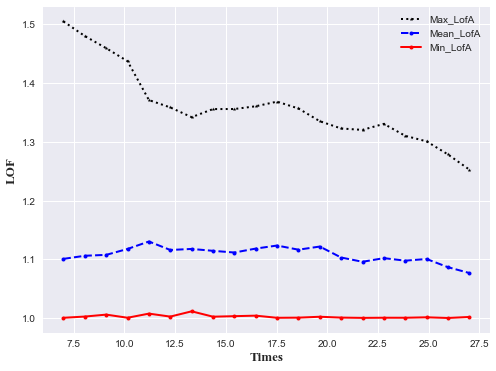

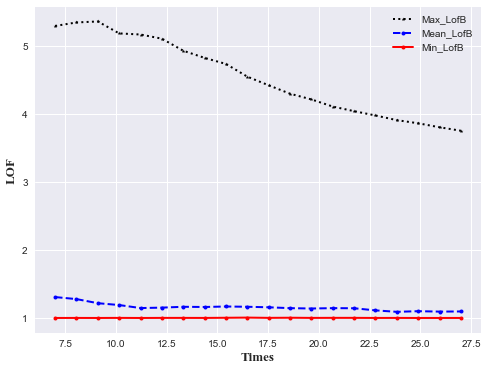

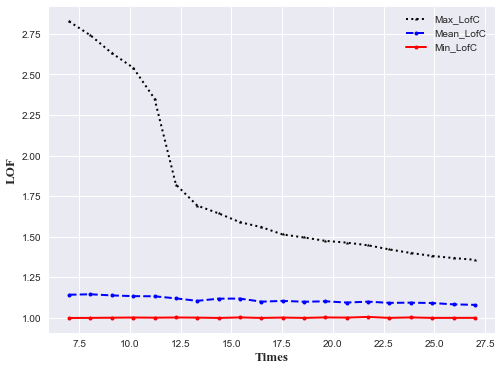

In [38]:
font = {'family':'Times new roman', 'weight':'normal', 'size': 13}  
plt.figure(figsize=(8, 6), facecolor='w')
ax = plt.subplot(1, 1, 1)
x_plot = np.linspace(7, 27, 20)
ax.plot(x_plot, Max_lof_A, 'k*:', markersize=4, linewidth=2, label='Max_LofA')
ax.plot(x_plot, Mean_lof_A, 'bo--', markersize=4, linewidth=2, label='Mean_LofA')
ax.plot(x_plot, Min_lof_A, 'ro-', markersize=4, linewidth=2, label='Min_LofA')
plt.legend()
plt.xlabel("Times", fontdict=font)
plt.ylabel("LOF", fontdict=font)
plt.show()


plt.figure(figsize=(8, 6), facecolor='w')
ax = plt.subplot(1, 1, 1)
x_plot = np.linspace(7, 27, 20)
ax.plot(x_plot, Max_lof_B, 'k*:', markersize=4, linewidth=2, label='Max_LofB')
ax.plot(x_plot, Mean_lof_B, 'bo--', markersize=4, linewidth=2, label='Mean_LofB')
ax.plot(x_plot, Min_lof_B, 'ro-', markersize=4, linewidth=2, label='Min_LofB')
plt.legend()
plt.xlabel("Times", fontdict=font)
plt.ylabel("LOF", fontdict=font)
plt.show()


plt.figure(figsize=(8, 6), facecolor='w')
ax = plt.subplot(1, 1, 1)
x_plot = np.linspace(7, 27, 20)
ax.plot(x_plot, Max_lof_C, 'k*:', markersize=4, linewidth=2, label='Max_LofC')
ax.plot(x_plot, Mean_lof_C, 'bo--', markersize=4, linewidth=2, label='Mean_LofC')
ax.plot(x_plot, Min_lof_C, 'ro-', markersize=4, linewidth=2, label='Min_LofC')
plt.legend()
plt.xlabel("Times", fontdict=font)
plt.ylabel("LOF", fontdict=font)
plt.show()

In [8]:
# 对于Instane2二维数据,取9~12都可以
# 对Instane5五维数据
lof = outliers(10, Instane5_B)
for outlier in lof:
#     if outlier["lof"]>1.5:
    print(outlier["lof"], outlier["instance"], outlier["index"])

5.183336993630886 [9.128396764357758, 0.9613324471452911, 0.8031343375397725, 0.9142870370606886, 0.6553611263265112] 118
1.7767735229314776 [-0.4477862315143532, -0.9613324471452911, 0.5173984678836734, -1.0560517759641201, -0.5989879220100891] 37
1.706309485621255 [4.283432840324724, 1.1749618798442447, 0.4168237644118636, -0.06784649371624153, -0.7447730528693162] 119
1.2608295016862368 [0.43638967865187367, 0.9613324471452911, -0.5226343033084413, 0.6358676520768723, 0.49026028250307707] 46
1.215753491570301 [-0.12063454396217987, 0.9613324471452911, -0.4766275400857543, -0.7220292785264476, 0.6552387577311946] 106
1.2104237923017505 [-0.30667223183068304, 1.1749618798442447, 0.04624806608444849, 0.6941833883783204, -0.5410712956329353] 83
1.184782321579515 [-0.3658175982719641, -0.5340735817473838, 0.4480509688722103, -0.628098872574942, -0.5579046568377903] 3
1.1807262376038585 [1.318236613800889, 0.9613324471452911, -0.40789792359791965, 0.45945853473094617, 0.7690690087835214] 

In [52]:
# 建立序列与故障对应的权重值，用于权重LOF，与权重贝叶斯
# Lof_Score为得分
import copy
# ================================================================
# Mean_Lof:求解每3组的LOF均值，用于判断是否为噪声点的条件
# Lof_Score：LOF得分原始输入，默认全部为1,返回对应的序列得分大小
# Instane5：输入为Instane5_A/B/C,用于计算大小
# lof为已经计算好的各省lof框架
# ================================================================
def Mean_Lof(Instane5, lof):
    Lof_Score = [1 for i in range(len(Instane5))]
    if len(Instane5)==132:
        MeanLof_Len = 11 #这里11需要根据省修改：取11或是7
    else:
        MeanLof_Len = 7
    #   序列得分赋值
    for outlier in lof:
        Lof_Score[outlier['index']] = outlier['lof']
    Lof_ScoreSort = [Lof_Score[i*12:(i+1)*12] for i in np.arange(MeanLof_Len)] 
    
    #     每三组得分均值计算与权重赋值
    Weight_matrix = copy.deepcopy(Lof_ScoreSort)
    Weight_matrix = np.array(Weight_matrix)
    Weight_matrix_T = Weight_matrix.T
    Mean_Lof = [0,0,0,0]
    Lof_ScoreSort = np.array(Lof_ScoreSort)
    Lof_ScoreSort_T = Lof_ScoreSort.T #转置一下，便于与均值作比较
    for i in range(4):
        Mean_Lof[i] = Lof_ScoreSort[:, (i*3):(3*(i+1))].sum()
        Mean_Lof[i] = Mean_Lof[i]/(3*MeanLof_Len)     #计算均值
        
        for j in range(3):
            A = Lof_ScoreSort_T[(i*3+j), :]   #定位到行
            for IP in range(11):
                B = A[IP]                     #定位到列
                if B < Mean_Lof[i]:
                    Weight_matrix_T[(i*3+j), IP] = 1  #权值赋值
                else:
                    Weight_matrix_T[(i*3+j), IP] = np.exp(-B/10)   #权值赋值,这条语句还需要修改
                
    Weight_matrix = Weight_matrix_T.T
    
    
    return Mean_Lof, Lof_Score, Weight_matrix

Mean_Lof_B, Lof_Score_B, Weight_matrix_B = Mean_Lof(Instane5_B, lof)

print(Mean_Lof_B)
print(Lof_Score_B)
print(Weight_matrix_B)
# for i in Weight_matrix_B:
#     for j in i:
#         print(j)

[1.0261996199825383, 1.0151569887590193, 1.0322301043219184, 1.197097517009559]
[1, 1, 1, 1.184782321579515, 1.0337102677283, 1, 1, 1.0333166593462926, 1, 1.1339513917178203, 1.0642530151351122, 1, 1, 1, 1.065519964263784, 1, 1, 1, 1.1326332633466036, 1.0362018253582703, 1, 1, 1.070763763412625, 1, 1, 1, 1, 1, 1, 1, 1, 1.0137975919694944, 1, 1, 1.0671847637600524, 1, 1, 1.7767735229314776, 1.0222939722284967, 1.026659912671214, 1.140269367782688, 1, 1.0770096876748378, 1.1683253219998515, 1, 1.0083491153015, 1.2608295016862368, 1, 1, 1, 1, 1, 1, 1, 1.0129057923143403, 1.0442906579364457, 1.1151785671587706, 1, 1.0563733870615482, 1, 1, 1, 1, 1, 1.032245640186082, 1, 1.0164077494413157, 1.0353470662750823, 1, 1.0145283381611818, 1.1807262376038585, 1, 1, 1, 1, 1, 1, 1, 1, 1.0318425355659764, 1, 1.071004023407609, 1.064996304004882, 1.2104237923017505, 1, 1, 1, 1, 1, 1, 1, 1.130395101887144, 1, 1, 1.0944610012026874, 1, 1, 1, 1, 1, 1, 1, 1.0111450742634924, 1.0369022266832704, 1, 1.00137

In [30]:
for i in range(len(Lof_Score_B)):
    if Lof_Score_B[i] > Mean_Lof_B
print(len(Instane5_B))

132


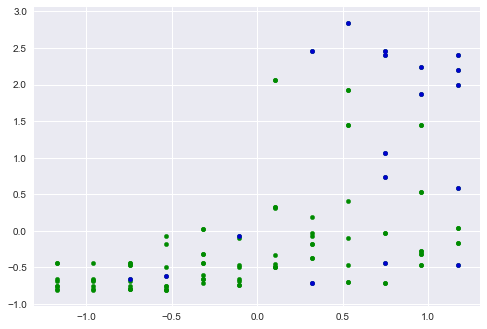

In [7]:
lof = outliers(10, Instane5_A)

x, y = zip(*Instane2_A)
plt.scatter(y, x, s=20, color="#008B00")


for outlier in lof:
    value = outlier["lof"]
    instance = outlier["instance"]
    if value>1.1 and value<=1.5:
        color = "#0000CD" #蓝色
    elif value > 1.5:
        color = "#FF0000"  #红色
    else:
        color = "#008B00"  #绿色
    plt.scatter(instance[1], instance[0], color=color, s=(value-1)**2*10+20)
plt.show()

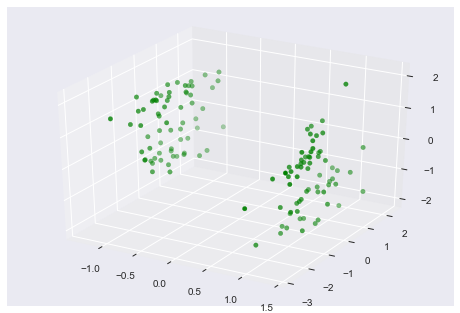

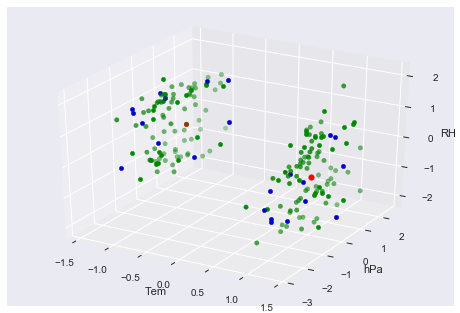

In [93]:
ax = plt.subplot(111, projection='3d')
ax.scatter(elec_RH1, elec_hPa1, elec_tem1, c='g')
plt.show()

ax = plt.subplot(111, projection='3d')
ax.scatter(elec_RH1, elec_hPa1, elec_tem1, c='g')
for outlier in lof:
    value = outlier["lof"]
    instance = outlier["instance"]
    
    if value>1.1 and value<=1.5:
        color = "#0000CD" #蓝色
    elif value > 1.5:
        color = "#FF0000"  #红色
    else:
        color = "#008B00"
    ax.scatter(instance[4], instance[3], instance[2],  c=color, s=(value-1)**2*10+20)
#     ax.scatter(instance[2], instance[1], instance[0],  c=color, s=(value-1)**2*10+20)
ax.set_zlabel('RH')  # 坐标轴
ax.set_ylabel('hPa')
ax.set_xlabel('Tem')
plt.show()

sklearn--Anomaly detection with Local Outlier Factor (LOF)
---

In [8]:
# fit the model
# clf = sl.neighbors.LocalOutlierFactor(n_neighbors=20)
# y_pred = clf.fit_predict(Instane5)
# y_pred_outliers = y_pred[10:]

Grubbs异常点检测
---

In [9]:
print(elec_faults2*100)

# =====================================================================================
# GrubbsList: 临界值，第一行为n=7,第二行为n=11，第一个数为0.95.第二个为0.99时的阈值
# GrubbS：计算elec_faults2每列的Grubbs值
# 输入值：Fault：排列好的故障率数据，每个地点一组数据，每组长度为12。elec_faults2
# 返回值：
#     Index.append(Max_line[0])              #返回每一组哪个数据的索引值
#     ZSCORE.append(Z_Score)                 #返回具体得分
#     II.append(i)                           #返回第几组索引
#     Value.append(Every_line[Max_line[0]])  #返回异常值对应原始值
# =====================================================================================
GrubbsList = [[1.938, 2.097], [2.176, 2.410]] 
LinJieZhi = 0 #0代表0.95；1代表取0.99
def GrubbS(Fault, LinJieZhi=1):
    Index = []
    ZSCORE = []
    II = []
    Value = []
    for i in np.arange(len(Fault.T)):
        Every_line = Fault[:, i]
        Mean_line = Every_line.mean() #计算均值
        Std_line = Every_line.std()   #计算标准差

        Temp = abs(Every_line - Mean_line)
        Max_line = np.where(Temp==np.max(Temp)) #返回最大值的索引
        Max_line = Max_line[0]        #返回索引

        Z_Score = Temp[Max_line[0]]/Std_line
        if len(Every_line)==7:   #确定是哪个省的数据，用于选择GrubbsList的行号
            JJ = 0
        if len(Every_line)==11:
            JJ = 1
            
        if Z_Score > GrubbsList[JJ][LinJieZhi]: #默认取0.95
            Index.append(Max_line[0])              #返回每一组哪个数据的索引值
            ZSCORE.append(Z_Score)                 #返回具体得分
            II.append(i)                           #返回第几组索引
            Value.append(Every_line[Max_line[0]])  #返回异常值对应原始值
    return Index, ZSCORE, II, Value

Max_index, Z_score, Hang_index, Max_Value = GrubbS(elec_faults2)
print(Max_index)
print(Hang_index)
print(Z_score)
print(Max_Value)

[[ 0.  0.  4.  3.  3.  3.  6.  5.  8.  6. 10.  6.]
 [ 0.  0.  1.  1.  3.  2.  3.  3.  2.  2.  8.  6.]
 [ 0.  0.  2.  1.  6.  6.  2.  2.  3.  2. 14. 13.]
 [ 1.  1.  5.  4. 30. 26. 23. 19. 25. 22. 22. 18.]
 [ 1.  1.  2.  2.  5.  4.  6.  5.  5.  5. 19. 15.]
 [ 2.  3.  3.  2. 52. 43.  9.  6. 49. 46. 43. 31.]
 [ 0.  0.  0.  0.  1.  0.  8.  6.  4.  3.  5.  4.]
 [ 0.  0.  1.  0.  3.  2. 19. 14. 13. 13. 15. 19.]
 [ 1.  0.  3.  3. 12. 17. 39. 31. 15. 13.  9. 12.]
 [ 0.  0.  3.  3. 11.  9. 33. 23. 13. 10. 96. 69.]
 [ 0.  0.  1.  0.  2.  2. 24. 23. 14. 16. 10.  8.]]
[5, 5, 5, 5, 5, 5, 9, 9]
[0, 1, 4, 5, 8, 9, 10, 11]
[2.544994774935888, 3.025846415214352, 2.6926810640520915, 2.5484898846797073, 2.7297074141559166, 2.7461046979694137, 2.9076660547459365, 2.8809798445643353]
[0.015306903413439462, 0.030613806826878923, 0.5204347160569417, 0.42859329557630493, 0.4898209092300628, 0.45920710240318385, 0.9598244892362539, 0.6855889208830386]
